# Exploratory Data Analysis (EDA)

**Notebook Name:** `01_data_exploration.ipynb`

**Objective:**  
Perform an in‐depth initial exploration of the Retail Sales Data (UCI) to understand data structure, quality, and underlying trends. This notebook extracts actionable insights for downstream preprocessing, forecasting, and anomaly detection. 

**Contents:**
- Environment Setup
- Data Loading & Initial Inspection
- Missing Values Analysis
- Cancellation Transactions Analysis
- Revenue Calculation & Validation
- Daily-Level Aggregations
- Monthly & Seasonal Trends Analysis
- Distribution & Outlier Analysis
- Product-Level Analysis
- Country-Level Analysis
- Correlation & Relationship Analysis
- Advanced Text Analysis (Creative Addition)
- RFM Customer Segmentation (Creative Addition)
- Cohort Analysis (Creative Addition)
- Key Findings & Next Steps

## 1. Environment Setup

We import the necessary libraries for data manipulation, plotting, date handling, and time-series analysis. We also set a consistent plot style for professional visuals.


In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from datetime import datetime

# For time series seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import chi2_contingency

# For text analysis (if needed)
from collections import Counter
import re

# Set global plot style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## 2. Data Loading and Initial Inspection

Load the dataset (CSV or Excel) and perform an initial inspection.  
Make sure to update the `data_path` variable to the correct file location.

In [2]:
# Define the file path to your dataset (adjust as needed)
data_path = "../data/interim/combined_retail_data.csv"  # or .xlsx if you have an Excel file

# Load dataset based on file extension
ext = os.path.splitext(data_path)[1].lower()
if ext in ['.xlsx', '.xls']:
    df = pd.read_excel(data_path)
    print(f"Dataset loaded from Excel: {data_path}")
elif ext == '.csv':
    df = pd.read_csv(data_path, encoding='latin1')
    print(f"Dataset loaded from CSV: {data_path}")
else:
    raise ValueError("Unsupported file format. Please use .csv or .xlsx")

Dataset loaded from CSV: ../data/interim/combined_retail_data.csv


In [3]:
# Standardize column names to expected list
STANDARD_COLUMNS = ['StockCode', 'Quantity', 'UnitPrice', 'InvoiceNo', 
                    'CustomerID', 'InvoiceDate', 'Description', 'Country']
rename_map = {"Invoice": "InvoiceNo", "Price": "UnitPrice", "Customer ID": "CustomerID"}
df = df.rename(columns=rename_map)

# Ensure all standard columns exist; if missing, add with NaN values
for col in STANDARD_COLUMNS:
    if col not in df.columns:
        print(f"Warning: Column '{col}' missing; adding it as NaN.")
        df[col] = np.nan
df = df[STANDARD_COLUMNS]

In [4]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())
print("\nData Types:\n", df.dtypes)
print("\nStatistical Summary (Numeric Columns):\n", df.describe())

Dataset Shape: (1067370, 8)

First 5 Rows:
   StockCode  Quantity  UnitPrice InvoiceNo  CustomerID         InvoiceDate  \
0     85048        12       6.95    489434     13085.0 2009-12-01 07:45:00   
1    79323P        12       6.75    489434     13085.0 2009-12-01 07:45:00   
2    79323W        12       6.75    489434     13085.0 2009-12-01 07:45:00   
3     22041        48       2.10    489434     13085.0 2009-12-01 07:45:00   
4     21232        24       1.25    489434     13085.0 2009-12-01 07:45:00   

                           Description         Country  
0  15CM CHRISTMAS GLASS BALL 20 LIGHTS  United Kingdom  
1                   PINK CHERRY LIGHTS  United Kingdom  
2                  WHITE CHERRY LIGHTS  United Kingdom  
3         RECORD FRAME 7" SINGLE SIZE   United Kingdom  
4       STRAWBERRY CERAMIC TRINKET BOX  United Kingdom  

Data Types:
 StockCode              object
Quantity                int64
UnitPrice             float64
InvoiceNo              object
CustomerID 

## 3. Enhanced Missing Values Analysis

We enhance our analysis to understand deeply structured patterns behind missing values in both `CustomerID` and `Description`.

### Objectives:
- Clearly visualize and quantify missingness.
- Identify relationships between missingness and other features.
- Provide strategies for addressing missing data in downstream tasks.

In [5]:
# Calculate and print missing values
missing_values = df.isnull().sum()
missing_percent = (df.isnull().mean() * 100).round(2)
missing_df = pd.DataFrame({"Missing": missing_values, "Percent": missing_percent})
print("Missing Values Analysis:\n", missing_df)

Missing Values Analysis:
              Missing  Percent
StockCode          0     0.00
Quantity           0     0.00
UnitPrice          0     0.00
InvoiceNo          0     0.00
CustomerID    243007    22.77
InvoiceDate        0     0.00
Description     4382     0.41
Country            0     0.00


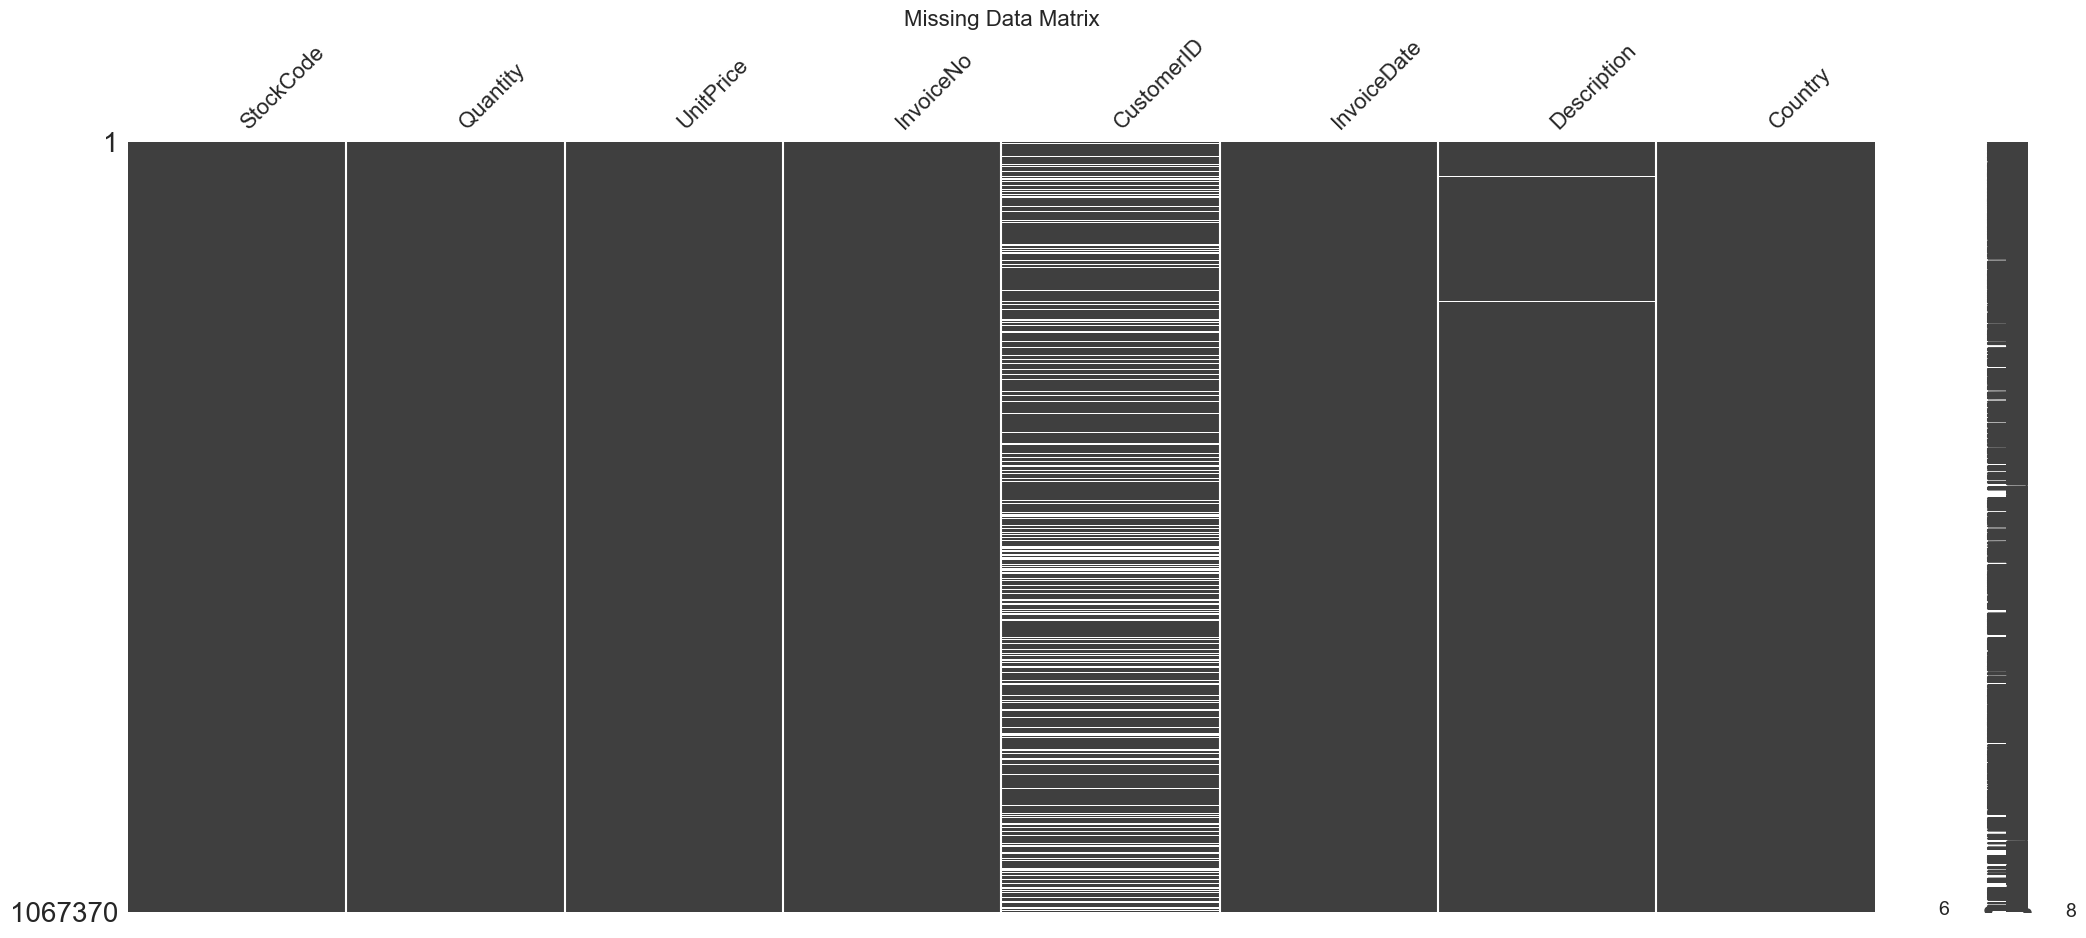

In [6]:
# Visualize missing data matrix
msno.matrix(df)
plt.title('Missing Data Matrix', fontsize=16)
plt.savefig('../data/reports/missing_data/plots/missing_data_matrix.png', dpi=300)
plt.show()

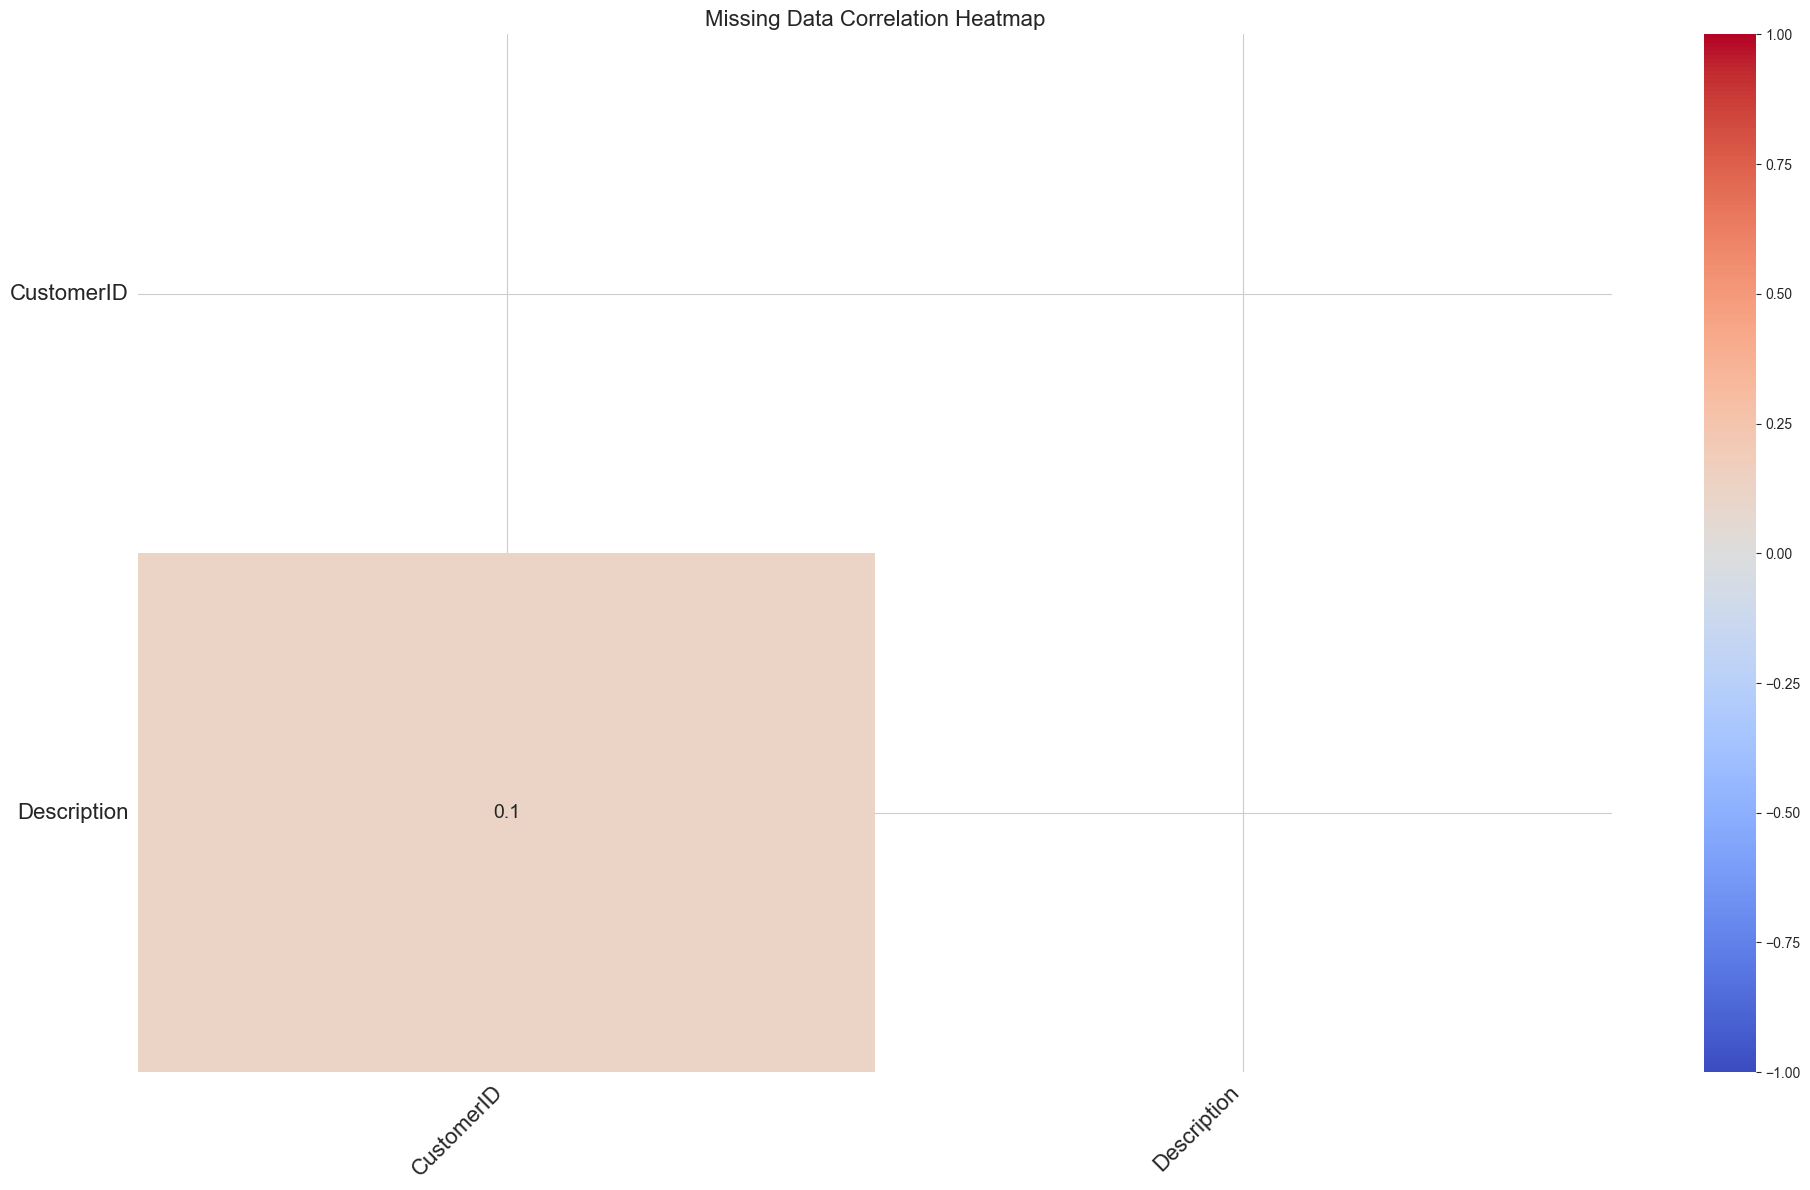

In [7]:
# Visualize missing data heatmap for correlations between missing values
msno.heatmap(df, cmap='coolwarm')
plt.title('Missing Data Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.savefig('../data/reports/missing_data/plots/missing_data_heatmap.png', dpi=300)
plt.show()

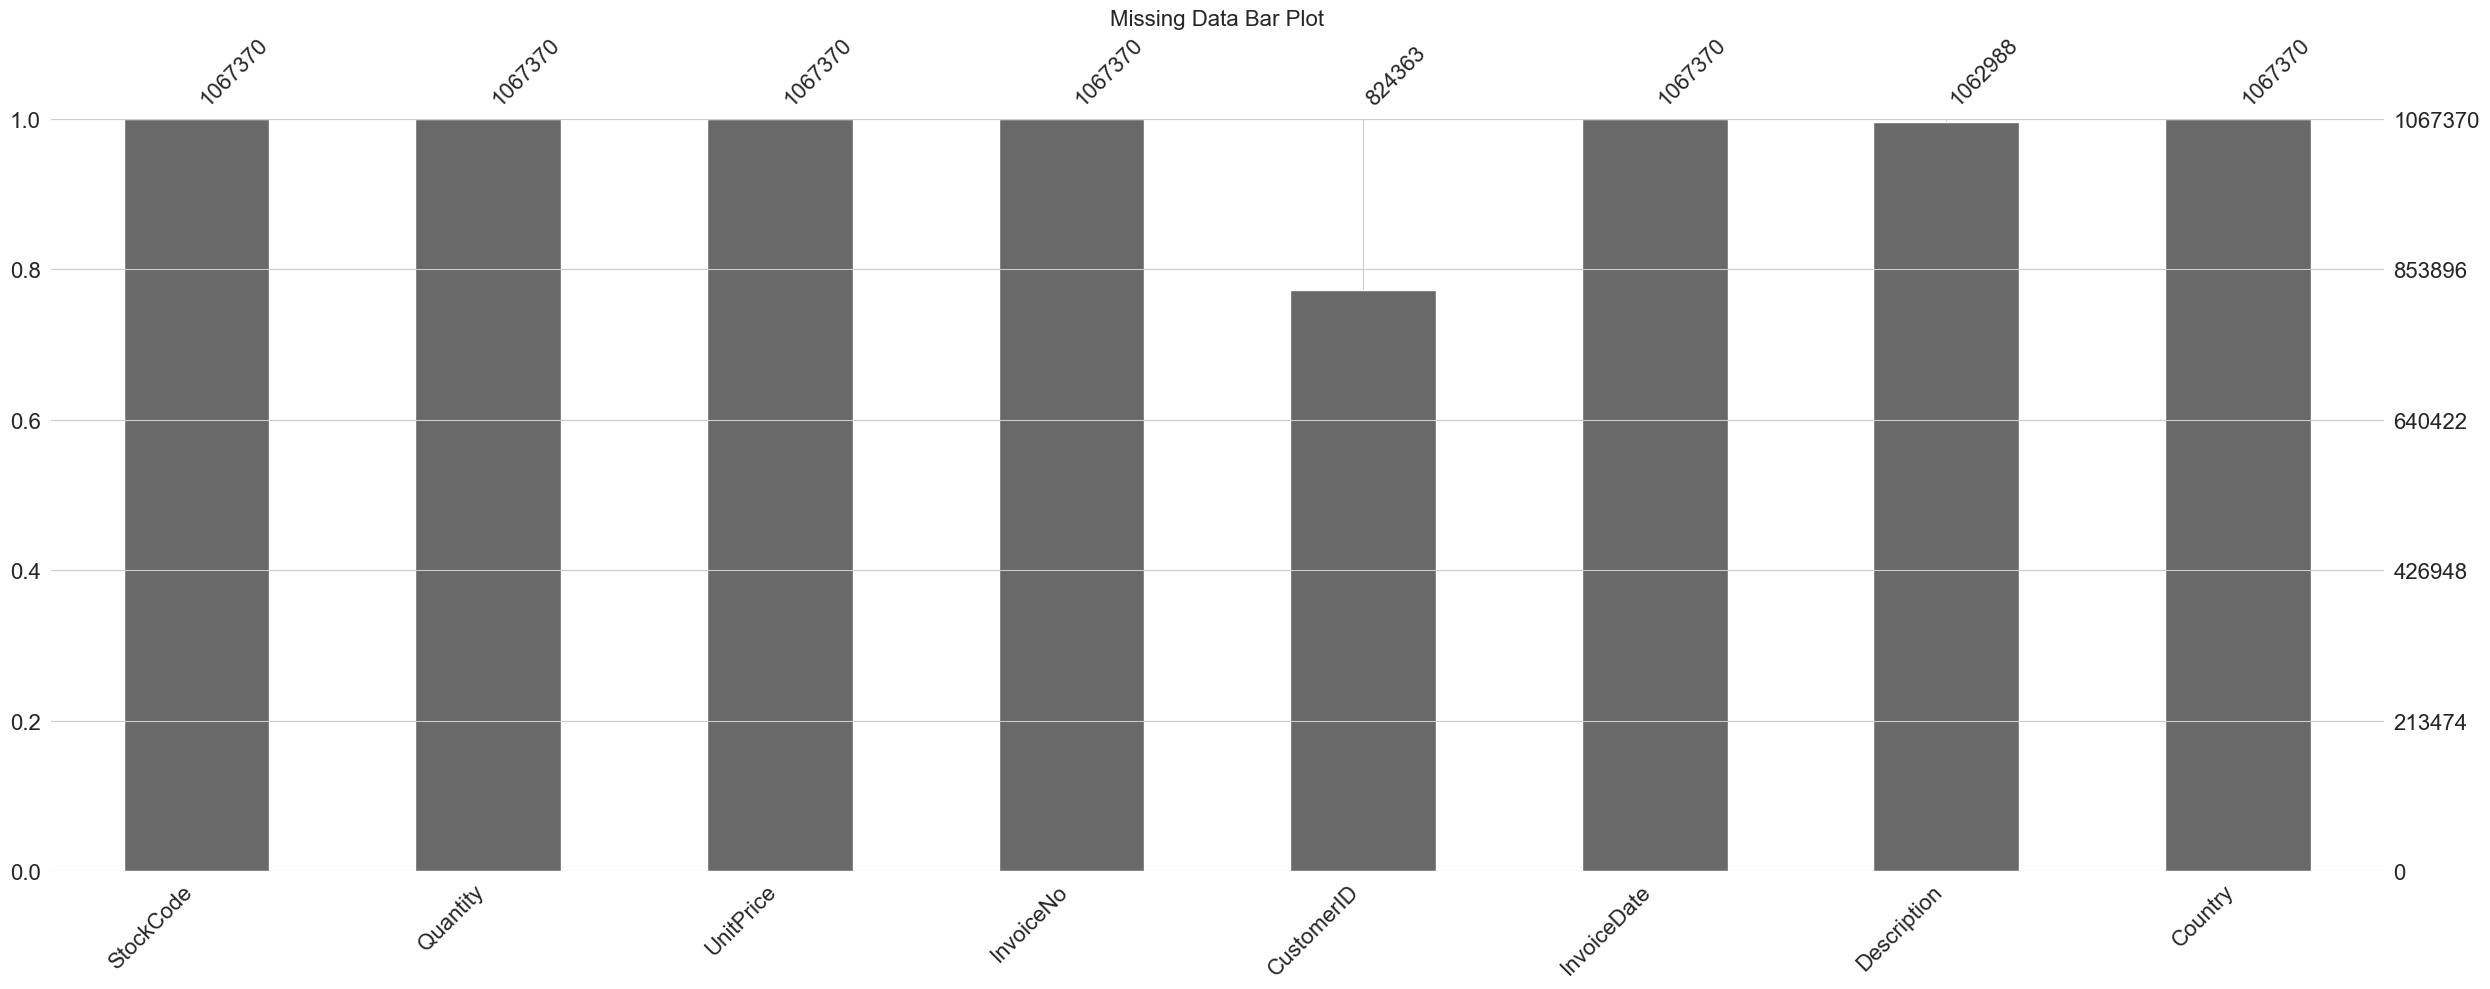

In [8]:
# Bar plot of missing data
msno.bar(df)
plt.title('Missing Data Bar Plot', fontsize=16)
plt.tight_layout()
plt.savefig('../data/reports/missing_data/plots/missing_data_barplot.png', dpi=300)
plt.show()

#### Quantitative Analysis: Correlations with Missing CustomerID

In [9]:
# Create indicator columns for missing CustomerID and Description
df_temp = df.copy()
df_temp['MissingCustomerID'] = df['CustomerID'].isnull().astype(int)
df_temp['MissingDescription'] = df['Description'].isnull().astype(int)

# Compute correlations
correlations = df_temp.corr(numeric_only=True)[['MissingCustomerID', 'MissingDescription']]
print("Correlations with Missingness:\n", correlations)

# Save correlations
correlations.to_csv('../data/reports/missing_data/missingness_correlations.csv')


Correlations with Missingness:
                     MissingCustomerID  MissingDescription
Quantity                    -0.026402           -0.010112
UnitPrice                    0.014499           -0.002416
CustomerID                        NaN                 NaN
MissingCustomerID            1.000000            0.118256
MissingDescription           0.118256            1.000000


#### Statistical Tests (Chi-square Test) for Missing CustomerID

In [10]:
def chi_square_test(feature, target):
    contingency_table = pd.crosstab(df_temp[feature], df_temp[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return {'chi2': chi2, 'p-value': p, 'dof': dof}

categorical_features = ['Country', 'StockCode', 'InvoiceNo', 'Quantity', 'UnitPrice']
chi_square_results = {}

for feature in categorical_features:
    print(f"Testing relationship between missing CustomerID and {feature}...")
    if df_temp[feature].nunique() < 50:  # limit to feasible computation
        result = chi_square_test(feature, 'MissingCustomerID')
        chi_square_results[feature] = result
        print(f"{feature} Chi2: {result['chi2']:.2f}, p-value: {result['p-value']:.4f}\n")
    else:
        print(f"Skipped {feature} (too many categories).\n")

# Save Chi-square results
chi_square_df = pd.DataFrame(chi_square_results).T
chi_square_df.to_csv('../data/reports/missing_data/chi_square_missing_customerID.csv')

Testing relationship between missing CustomerID and Country...
Country Chi2: 23345.36, p-value: 0.0000

Testing relationship between missing CustomerID and StockCode...
Skipped StockCode (too many categories).

Testing relationship between missing CustomerID and InvoiceNo...
Skipped InvoiceNo (too many categories).

Testing relationship between missing CustomerID and Quantity...
Skipped Quantity (too many categories).

Testing relationship between missing CustomerID and UnitPrice...
Skipped UnitPrice (too many categories).



#### Statistical Tests (Chi-square Test) for Missing Description

In [11]:
chi_square_results_desc = {}

for feature in categorical_features:
    print(f"Testing relationship between missing Description and {feature}...")
    if df_temp[feature].nunique() < 50:
        result = chi_square_test(feature, 'MissingDescription')
        chi_square_results_desc[feature] = result
        print(f"{feature} Chi2: {result['chi2']:.2f}, p-value: {result['p-value']:.4f}\n")
    else:
        print(f"Skipped {feature} (too many categories).\n")

# Save Chi-square results
chi_square_desc_df = pd.DataFrame(chi_square_results_desc).T
chi_square_desc_df.to_csv('../data/reports/missing_data/chi_square_missing_description.csv')

Testing relationship between missing Description and Country...
Country Chi2: 385.78, p-value: 0.0000

Testing relationship between missing Description and StockCode...
Skipped StockCode (too many categories).

Testing relationship between missing Description and InvoiceNo...
Skipped InvoiceNo (too many categories).

Testing relationship between missing Description and Quantity...
Skipped Quantity (too many categories).

Testing relationship between missing Description and UnitPrice...
Skipped UnitPrice (too many categories).



## 4. Cancellation Transactions Analysis

Invoices that start with the letter "C" represent cancellations.  
We extract these transactions and analyze their frequency and monthly trends.

In [12]:
# Create 'Month' column first
df['Month'] = df['InvoiceDate'].dt.to_period("M").astype(str)

# Filter cancellation transactions
cancellations = df[df['InvoiceNo'].astype(str).str.startswith('C')]

# Compute basic stats
total_invoices = df.shape[0]
cancellation_rate = (cancellations.shape[0] / total_invoices) * 100

print(f"Total Invoices: {total_invoices}")
print(f"Cancellation Invoices: {cancellations.shape[0]} ({cancellation_rate:.2f}%)")

# Group cancellations by month
cancel_monthly = cancellations.groupby('Month')['InvoiceNo'].count().reset_index()
cancel_monthly.columns = ['Month', 'CancellationCount']

Total Invoices: 1067370
Cancellation Invoices: 19494 (1.83%)


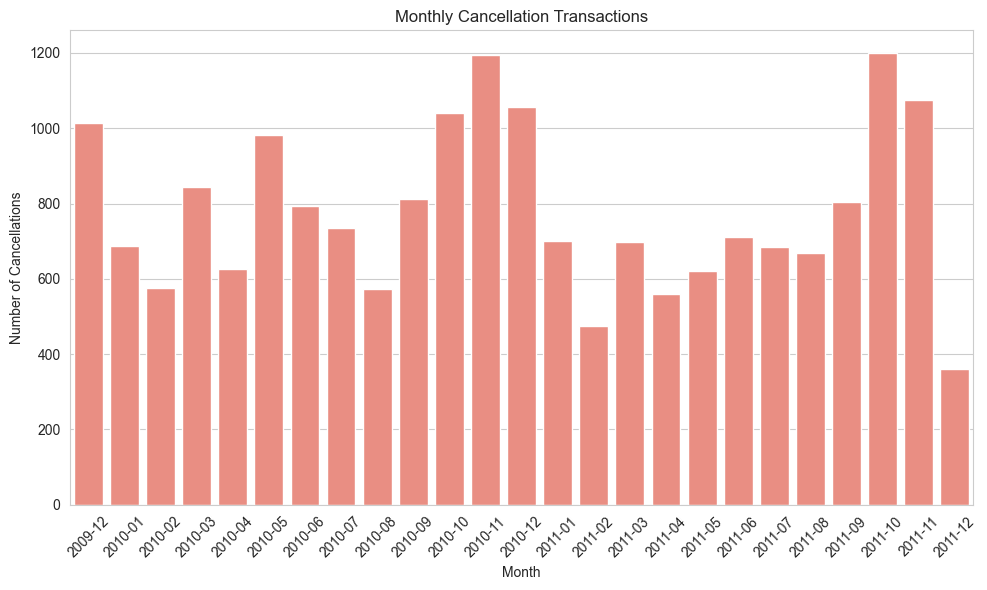

In [13]:
# Plot monthly cancellation trends
plt.figure(figsize=(10, 6))
sns.barplot(data=cancel_monthly, x='Month', y='CancellationCount', color='salmon')
plt.xticks(rotation=45)
plt.title("Monthly Cancellation Transactions")
plt.xlabel("Month")
plt.ylabel("Number of Cancellations")
plt.tight_layout()
plt.show()

## 5. Revenue Calculation and Validation

Compute revenue for each transaction as `UnitPrice * Quantity`.  
Check for negative or zero revenues that might indicate refunds or data-entry errors.

In [14]:
# Compute revenue
df['Revenue'] = df['UnitPrice'] * df['Quantity']
print("Revenue calculated for each transaction.")

# Identify negative or zero revenues
invalid_revenue = df[df['Revenue'] <= 0]
print("\nNumber of transactions with non-positive revenue:", invalid_revenue.shape[0])

Revenue calculated for each transaction.

Number of transactions with non-positive revenue: 25700


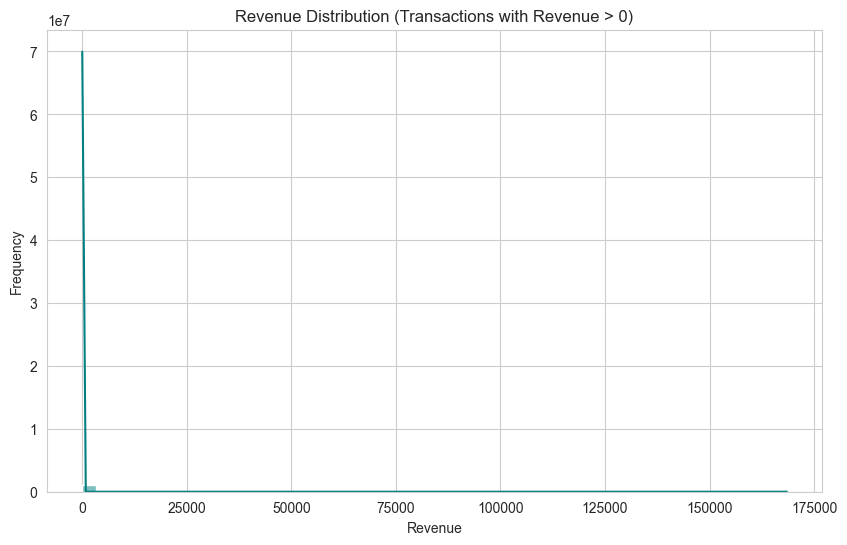

In [15]:
# Plot revenue distribution (excluding extreme negative values)
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Revenue'] > 0]['Revenue'], bins=50, kde=True, color='teal')
plt.title("Revenue Distribution (Transactions with Revenue > 0)")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.show()

## 6. Daily-Level Aggregations

Aggregate transaction data on a daily basis.  
Metrics include total daily revenue, transaction count, total quantity, and Average Order Value (AOV).

In [16]:
# Ensure InvoiceDate is a proper datetime and create a 'Date' column
df['Date'] = df['InvoiceDate'].dt.date

# Group daily
daily_data = df.groupby('Date').agg({
    'Revenue': 'sum',
    'InvoiceNo': pd.Series.nunique,
    'Quantity': 'sum'
}).rename(columns={'InvoiceNo': 'TransactionCount'})
daily_data['AOV'] = daily_data['Revenue'] / daily_data['TransactionCount']

print("Daily-Level Aggregated Data (First 5 Rows):")
print(daily_data.head())

Daily-Level Aggregated Data (First 5 Rows):
             Revenue  TransactionCount  Quantity         AOV
Date                                                        
2009-12-01  53173.03               166     24022  320.319458
2009-12-02  62763.59               133     29942  471.906692
2009-12-03  68093.05               150     44896  453.953667
2009-12-04  40346.40               107     21001  377.069159
2009-12-05   9803.05                32      5033  306.345312


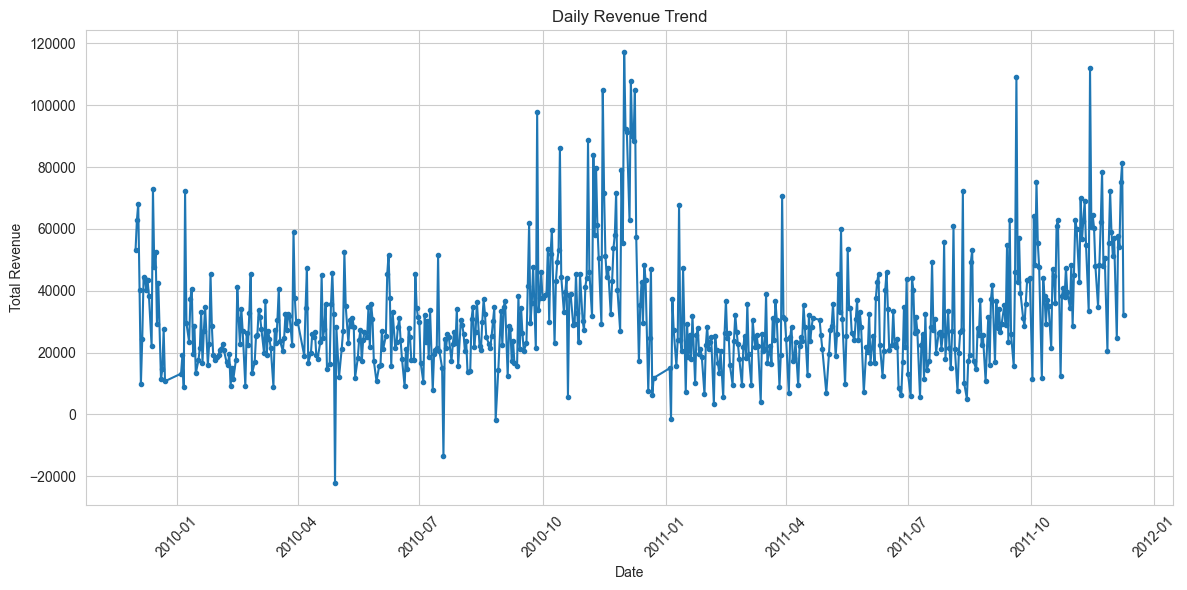

In [17]:
# Plot daily revenue trend (sample over time)
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data['Revenue'], marker='.', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Total Revenue")
plt.title("Daily Revenue Trend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Monthly and Seasonal Trends Analysis

Aggregate data by month to reveal seasonal and trend patterns.  
We also decompose the monthly revenue time series to inspect seasonality and residual components.


Monthly Revenue Summary:
       Month      Revenue
0   2009-12   799847.110
1   2010-01   624032.892
2   2010-02   533091.426
3   2010-03   765848.761
4   2010-04   590580.432
5   2010-05   615322.830
6   2010-06   679786.610
7   2010-07   575236.360
8   2010-08   656776.340
9   2010-09   853650.431
10  2010-10  1045168.350
11  2010-11  1422654.642
12  2010-12  1126445.470
13  2011-01   560000.260
14  2011-02   498062.650
15  2011-03   683267.080
16  2011-04   493207.121
17  2011-05   723333.510
18  2011-06   691123.120
19  2011-07   681300.111
20  2011-08   682680.510
21  2011-09  1019687.622
22  2011-10  1070704.670
23  2011-11  1461756.250
24  2011-12   433668.010


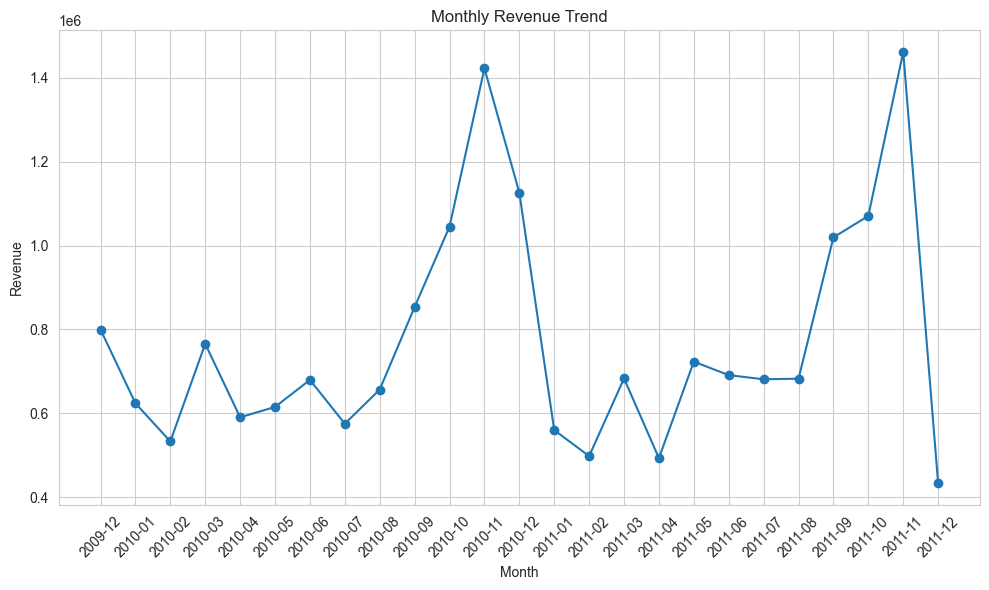

In [18]:
# Group by month
monthly_data = df.groupby('Month').agg({'Revenue': 'sum'}).reset_index()
print("Monthly Revenue Summary:\n", monthly_data)

# Plot the monthly revenue trend
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['Month'], monthly_data['Revenue'], marker='o')
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

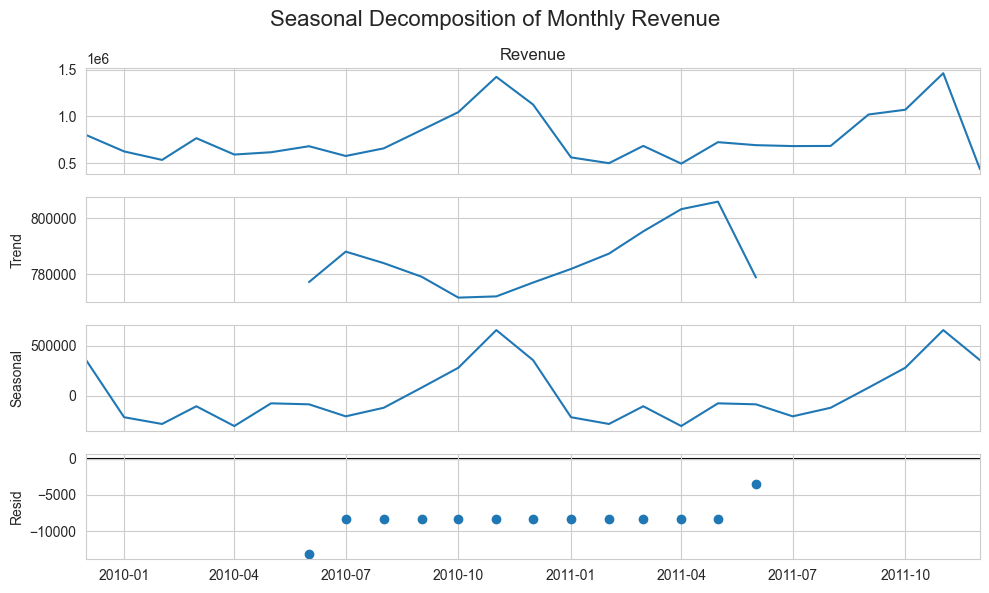

In [19]:
# Seasonal decomposition (using monthly frequency)
# Set the index as a datetime type (first day of each month)
monthly_series = monthly_data.copy()
monthly_series['Month_dt'] = pd.to_datetime(monthly_series['Month'] + "-01")
monthly_series.set_index('Month_dt', inplace=True)
monthly_series = monthly_series.sort_index()

# Decompose the revenue time series (period=12, suitable for annual seasonality)
decomposition = seasonal_decompose(monthly_series['Revenue'], model='additive', period=12)
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Monthly Revenue", fontsize=16)
plt.tight_layout()
plt.show()

## 8. Distribution and Outlier Analysis

Examine the distribution of `Quantity` and `UnitPrice` using histograms and boxplots.  
Compute skewness and kurtosis to quantify distribution shape.  
Apply log-scale transformations if necessary.

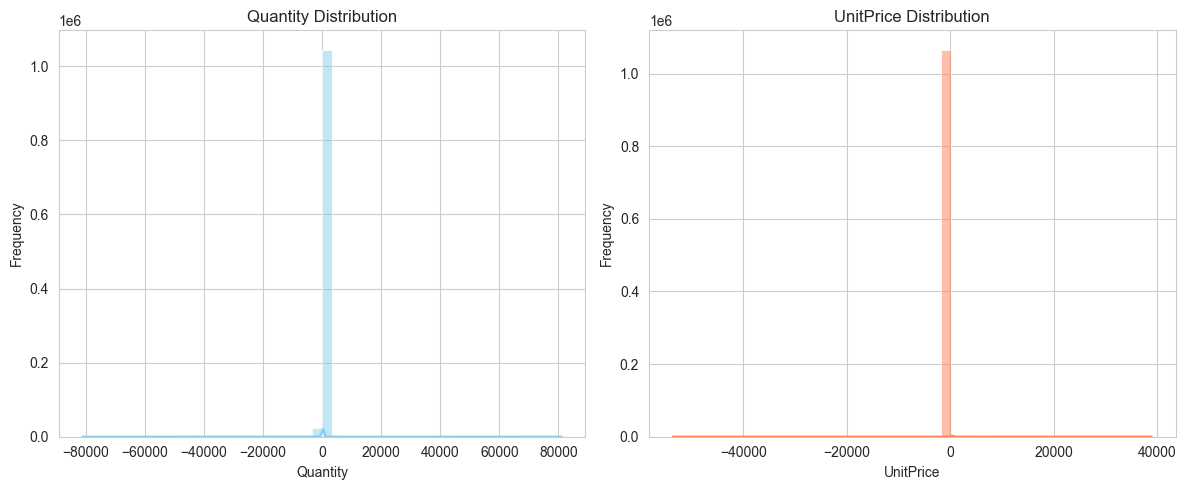

In [20]:
# Histograms for Quantity and UnitPrice
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Quantity'], bins=50, color='skyblue', kde=True)
plt.title("Quantity Distribution")
plt.xlabel("Quantity")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(df['UnitPrice'], bins=50, color='coral', kde=True)
plt.title("UnitPrice Distribution")
plt.xlabel("UnitPrice")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

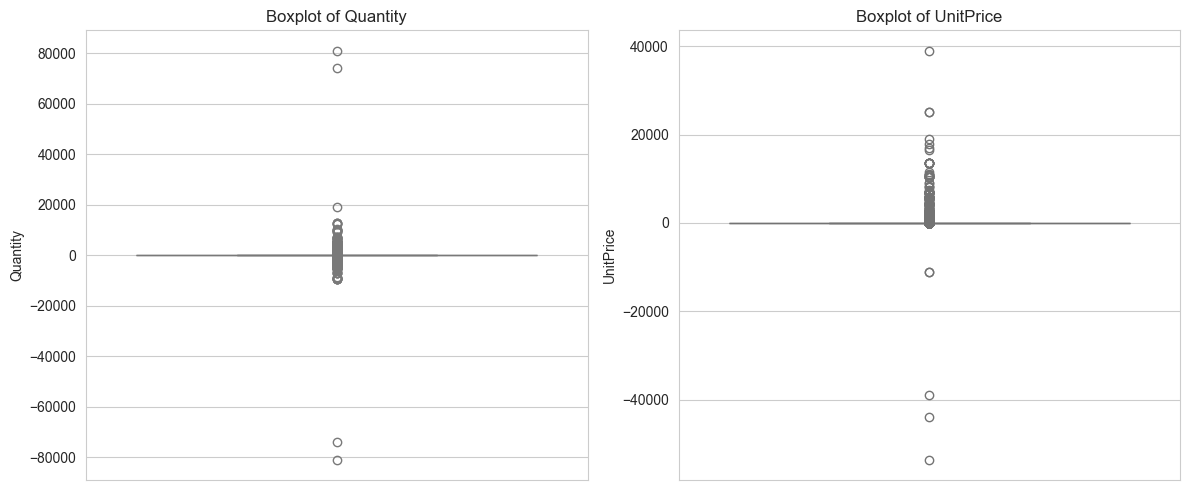

In [21]:
# Boxplots for outlier detection
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Quantity'], color='lightblue')
plt.title("Boxplot of Quantity")

plt.subplot(1, 2, 2)
sns.boxplot(y=df['UnitPrice'], color='lightgreen')
plt.title("Boxplot of UnitPrice")
plt.tight_layout()
plt.show()

In [22]:
# Compute skewness and kurtosis
skewness = df[['Quantity', 'UnitPrice']].skew()
kurtosis = df[['Quantity', 'UnitPrice']].kurt()
print("Skewness:\n", skewness)
print("\nKurtosis:\n", kurtosis)

Skewness:
 Quantity      3.996143
UnitPrice   -69.164702
dtype: float64

Kurtosis:
 Quantity     155059.548905
UnitPrice     73751.761442
dtype: float64


## 9. Product-Level Analysis

Identify the top 10 products by total quantity sold and by revenue.  
Visualize these top products with horizontal bar plots and consider a Pareto analysis.


In [23]:
# Group by product description
product_stats = df.groupby('Description').agg(
    Total_Quantity=('Quantity', 'sum'),
    Total_Revenue=('Revenue', 'sum'),
    Transaction_Count=('InvoiceNo', 'nunique')
).reset_index()

# Top 10 by total quantity sold
top10_qty = product_stats.sort_values(by='Total_Quantity', ascending=False).head(10)
print("Top 10 Products by Total Quantity Sold:\n", top10_qty)

# Top 10 by total revenue
top10_rev = product_stats.sort_values(by='Total_Revenue', ascending=False).head(10)
print("\nTop 10 Products by Total Revenue:\n", top10_rev)

Top 10 Products by Total Quantity Sold:
                              Description  Total_Quantity  Total_Revenue  \
5388   WORLD WAR 2 GLIDERS ASSTD DESIGNS          108545       24898.22   
5266  WHITE HANGING HEART T-LIGHT HOLDER           93050      257533.90   
328        ASSORTED COLOUR BIRD ORNAMENT           81306      131413.85   
2508             JUMBO BAG RED RETROSPOT           78090      148800.64   
801                  BROCADE RING PURSE            70700       14743.41   
3204  PACK OF 60 PINK PAISLEY CAKE CASES           56575       28373.68   
168          60 TEATIME FAIRY CAKE CASES           54366       27216.27   
4706                SMALL POPCORN HOLDER           49616       43809.96   
3207     PACK OF 72 RETROSPOT CAKE CASES           49344       28688.28   
3206    PACK OF 72 RETRO SPOT CAKE CASES           46106       23759.26   

      Transaction_Count  
5388               1032  
5266               5594  
328                2827  
2508               3344  
801

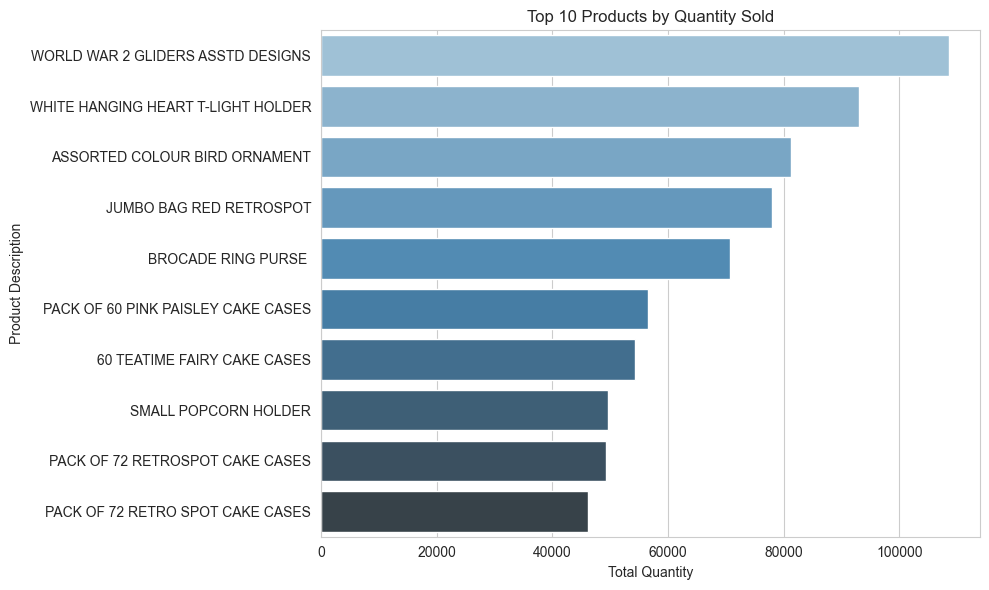

In [24]:
# Generate colors manually using the palette
color_blue = sns.color_palette("Blues_d", len(top10_qty))

# Plot horizontal bar chart with manual color assignment
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Total_Quantity",
    y="Description",
    hue="Description",             # Explicitly set hue to match y
    data=top10_qty,
    palette=color_blue,
    legend=False                   # Hide redundant legend
)
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Total Quantity")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()

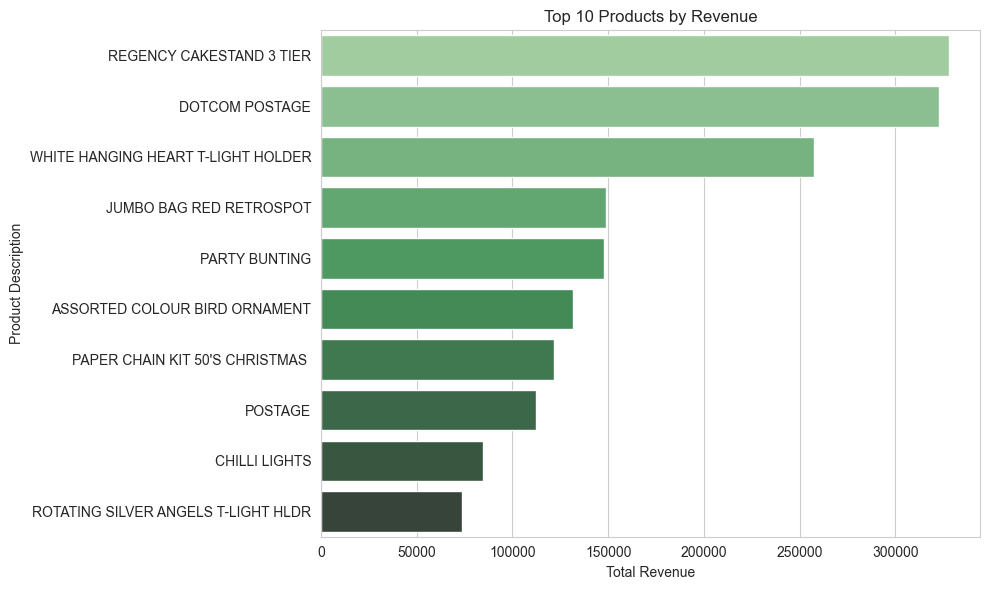

In [25]:
color_green = sns.color_palette("Greens_d", len(top10_rev))
# Plot horizontal bar chart for top revenue products
plt.figure(figsize=(10, 6))
sns.barplot(x="Total_Revenue", y="Description", hue="Description", data=top10_rev, palette=color_green)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()

## 10. Country-Level Analysis

Analyze revenue and transaction counts by country.  
Visualize the breakdown via bar plots. Note that the United Kingdom is expected to dominate.

In [26]:
# Group by country for analysis
country_stats = df.groupby('Country').agg(
    Transactions=('InvoiceNo', 'count'),
    Total_Revenue=('Revenue', 'sum')
).reset_index().sort_values(by='Total_Revenue', ascending=False)
print("Country-Level Analysis (by Total Revenue):\n", country_stats)

Country-Level Analysis (by Total Revenue):
                  Country  Transactions  Total_Revenue
40        United Kingdom        981330   1.638258e+07
11                  EIRE         17866   6.155196e+05
26           Netherlands          5140   5.485249e+05
15               Germany         17624   4.179886e+05
14                France         14329   3.281738e+05
0              Australia          1913   1.671291e+05
36           Switzerland          3189   9.972876e+04
34                 Spain          3811   9.185948e+04
35                Sweden          1364   8.780942e+04
10               Denmark           817   6.574109e+04
3                Belgium          3123   6.357449e+04
30              Portugal          2620   5.313680e+04
21                 Japan           582   4.377658e+04
7        Channel Islands          1664   4.145361e+04
28                Norway          1455   3.924303e+04
20                 Italy          1534   3.067935e+04
13               Finland          1049

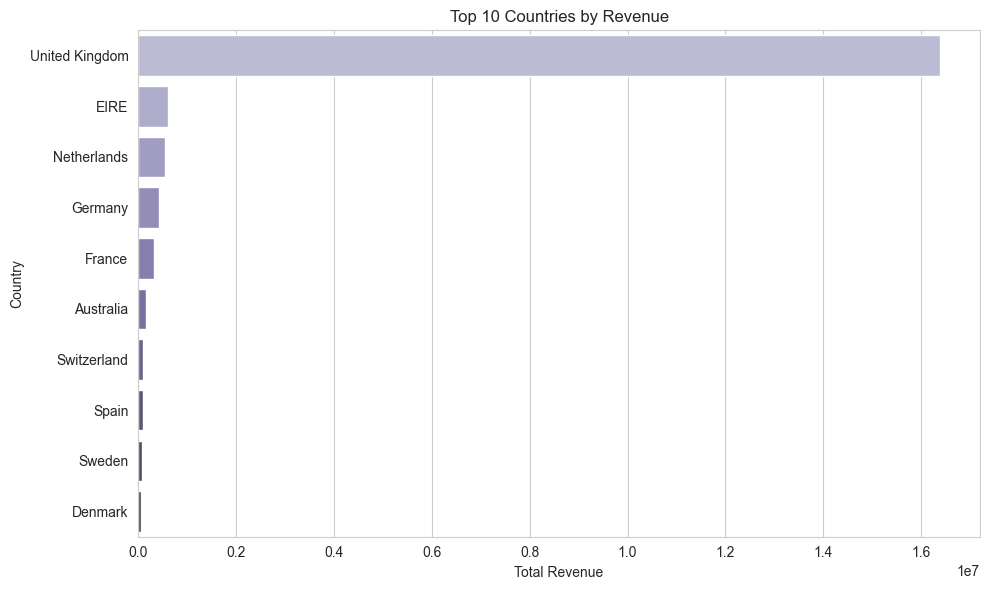

In [27]:
# Bar plot for total revenue by country (displaying top 10 for clarity)
top10_countries = country_stats.head(10)
color_purplr = sns.color_palette("Purples_d", len(top10_countries))

plt.figure(figsize=(10, 6))
sns.barplot(x="Total_Revenue", y="Country", hue="Country", data=top10_countries, palette="Purples_d")
plt.title("Top 10 Countries by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

## 11. Correlation and Relationship Analysis

Generate a correlation matrix for numeric features.  
Visualize pairwise relationships with pairplots and explore the relationship between UnitPrice and Quantity via scatter plots with regression.

Correlation Matrix:
             Quantity  UnitPrice  CustomerID   Revenue
Quantity    1.000000  -0.001319   -0.005430  0.762623
UnitPrice  -0.001319   1.000000   -0.003835  0.061029
CustomerID -0.005430  -0.003835    1.000000 -0.003122
Revenue     0.762623   0.061029   -0.003122  1.000000


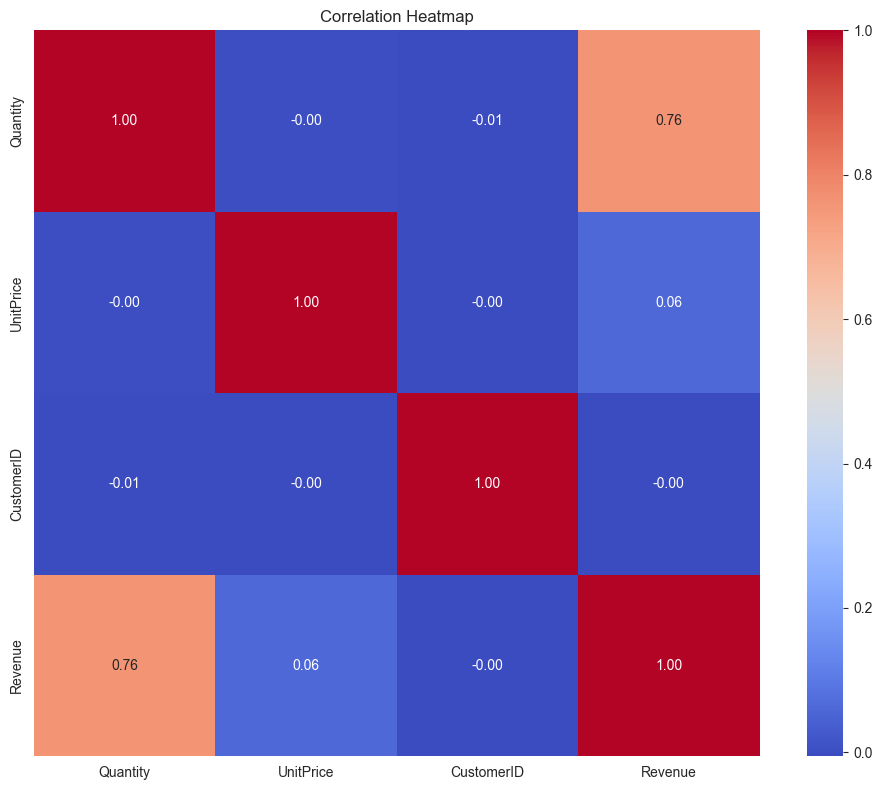

In [28]:
# Correlation matrix for numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()
print("Correlation Matrix:\n", corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

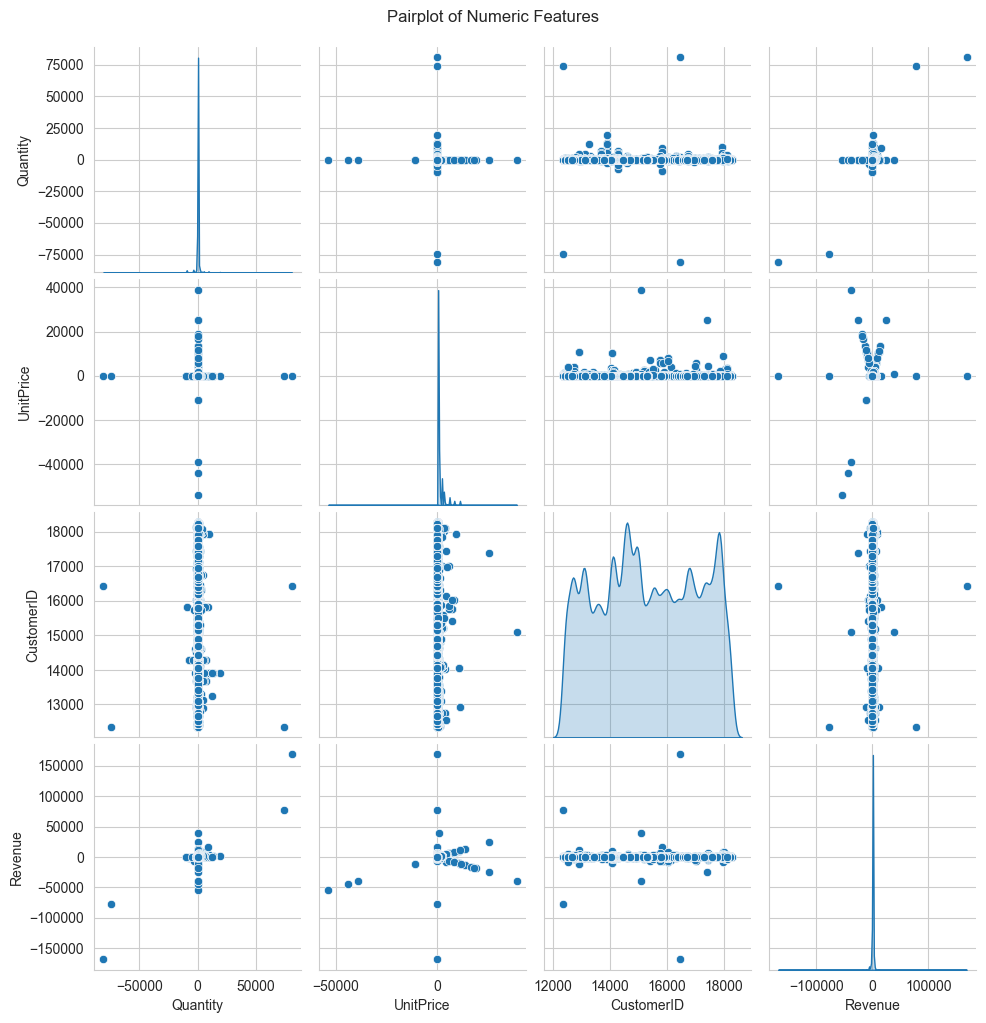

In [29]:
# Pairplot of numeric features
sns.pairplot(df[numeric_cols], diag_kind="kde")
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()

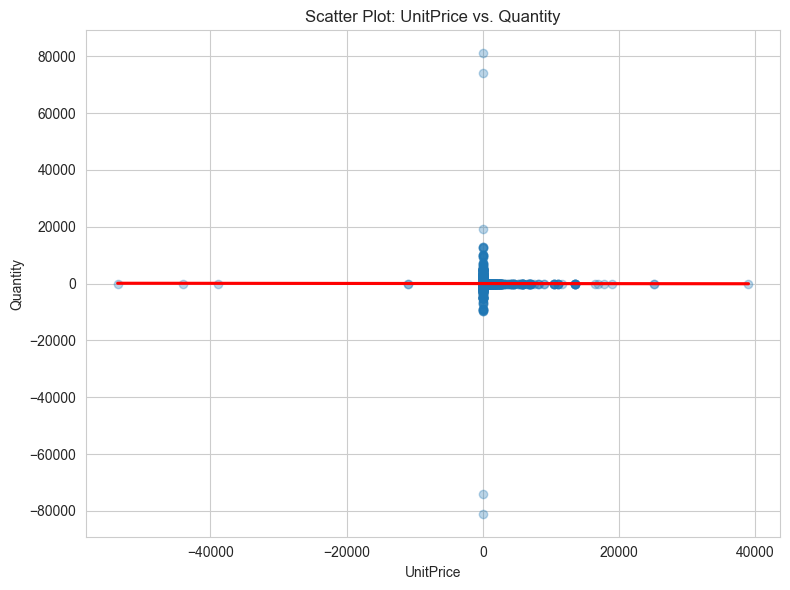

In [30]:
# Scatter plot for UnitPrice vs. Quantity with regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='UnitPrice', y='Quantity', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title("Scatter Plot: UnitPrice vs. Quantity")
plt.xlabel("UnitPrice")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()

## 12. Advanced Text Analysis (Creative Addition)

Perform a basic text analysis on the `Description` field to:
- Clean the text.
- Compute word frequencies.
- Visualize the most common words in a bar chart.

In [31]:
# Filter out missing descriptions and lower the text
descriptions = df['Description'].dropna().str.lower()

# Remove punctuation and numbers (simple cleaning)
cleaned = descriptions.apply(lambda x: re.sub('[^a-zA-Z\s]', '', x))
all_words = " ".join(cleaned).split()

# Count word frequencies and get the top 20
word_counts = Counter(all_words)
common_words = word_counts.most_common(20)

Top 20 most common words in product descriptions:
          Word  Frequency
0         set     115058
1         bag      92682
2          of      92611
3         red      90500
4       heart      78666
5        pink      63542
6   retrospot      58799
7     vintage      55618
8      design      54232
9         box      50857
10      white      48406
11       cake      46125
12      metal      44988
13  christmas      44557
14       blue      40167
15    hanging      37100
16      jumbo      35186
17     holder      35183
18       sign      34903
19       pack      32368


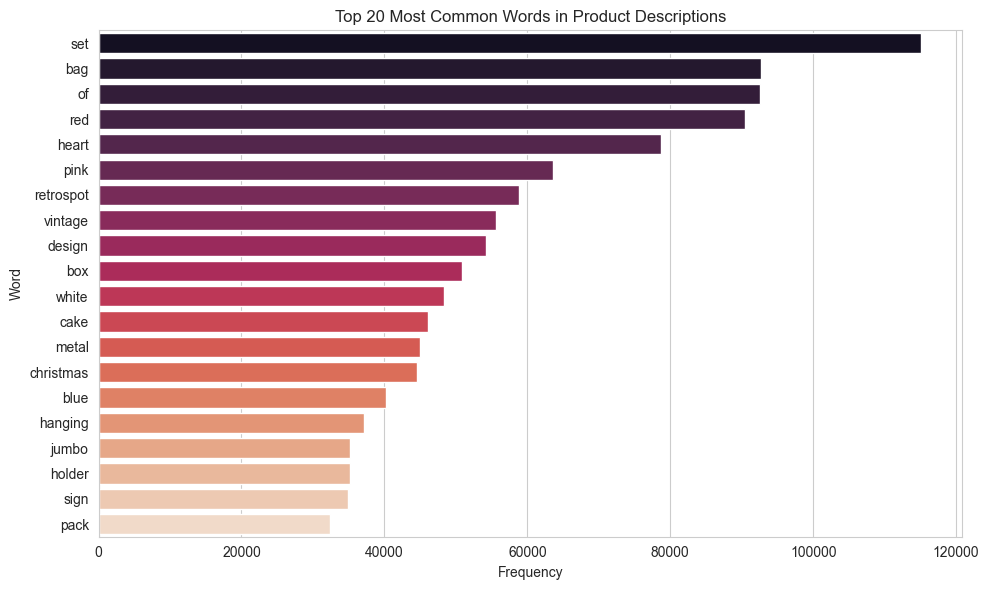

In [32]:
# Convert to DataFrame for visualization
common_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])
print("Top 20 most common words in product descriptions:\n", common_df)

# Plot the top 20 words
plt.figure(figsize=(10, 6))
sns.barplot(data=common_df, x="Frequency", y="Word", hue="Word", palette="rocket")
plt.title("Top 20 Most Common Words in Product Descriptions")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

## 13. RFM (Recency-Frequency-Monetary) Customer Segmentation (Creative Addition)

Segment customers based on:
- **Recency:** Days since the last purchase.
- **Frequency:** Number of transactions per customer.
- **Monetary:** Total revenue per customer.

_Note: Many transactions have missing CustomerIDs. These are excluded from segmentation._

In [33]:
# Exclude transactions with missing CustomerID
rfm_df = df.dropna(subset=['CustomerID']).copy()

# Compute Recency (difference between the last date in the dataset and each customer’s most recent purchase)
max_date = df['InvoiceDate'].max()
rfm_agg = rfm_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Revenue': 'sum'
}).reset_index()
rfm_agg.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("RFM Summary (First 5 Rows):\n", rfm_agg.head())

RFM Summary (First 5 Rows):
    CustomerID  Recency  Frequency  Monetary
0     12346.0      325         17    -64.68
1     12347.0        1          8   5633.32
2     12348.0       74          5   2019.40
3     12349.0       18          5   4404.54
4     12350.0      309          1    334.40


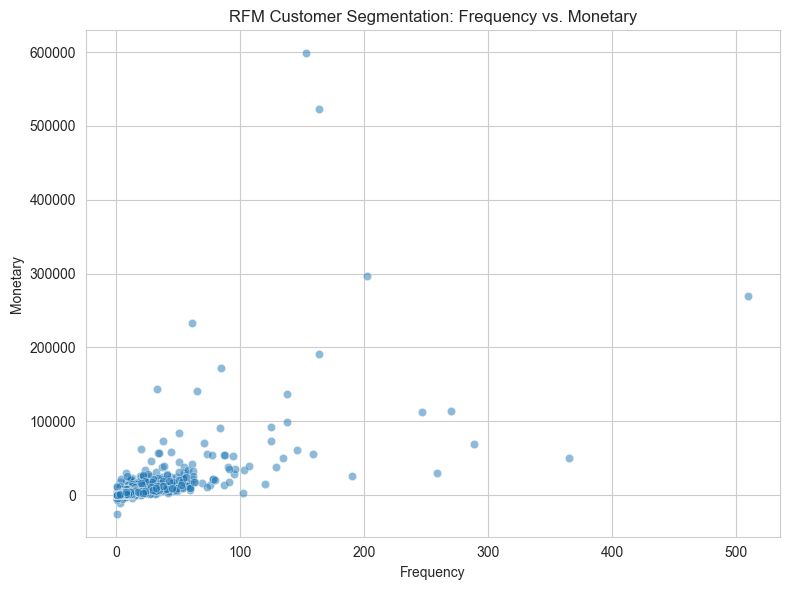

In [34]:
# Scatter plots to inspect segmentation (e.g., Frequency vs. Monetary)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Frequency', y='Monetary', data=rfm_agg, alpha=0.5)
plt.title("RFM Customer Segmentation: Frequency vs. Monetary")
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.tight_layout()
plt.show()

## 14. Cohort Analysis (Creative Addition)

Perform a cohort analysis by grouping customers based on the month of their first purchase.  
Then analyze the retention rates over subsequent months.

In [35]:
# Create a cohort group for each customer based on their first purchase date
cohort_df = df.dropna(subset=['CustomerID']).copy()
cohort_df['InvoiceMonth'] = cohort_df['InvoiceDate'].dt.to_period('M').astype(str)

# Determine each customer’s cohort (first purchase month)
first_purchase = cohort_df.groupby('CustomerID')['InvoiceMonth'].min().reset_index()
first_purchase.columns = ['CustomerID', 'CohortMonth']

# Merge the cohort information back into the dataset
cohort_df = pd.merge(cohort_df, first_purchase, on='CustomerID')

Cohort Analysis Pivot Table (Customer Counts):
 InvoiceMonth  2009-12  2010-01  2010-02  2010-03  2010-04  2010-05  2010-06  \
CohortMonth                                                                   
2009-12        1045.0    392.0    358.0    447.0    410.0    408.0    408.0   
2010-01           NaN    394.0     86.0    119.0    120.0    110.0    115.0   
2010-02           NaN      NaN    363.0    109.0     82.0    110.0     93.0   
2010-03           NaN      NaN      NaN    436.0     95.0    113.0    103.0   
2010-04           NaN      NaN      NaN      NaN    291.0     67.0     58.0   

InvoiceMonth  2010-07  2010-08  2010-09  ...  2011-03  2011-04  2011-05  \
CohortMonth                              ...                              
2009-12         374.0    355.0    392.0  ...    319.0    273.0    316.0   
2010-01         105.0     91.0    114.0  ...     71.0     60.0     86.0   
2010-02          76.0     79.0    103.0  ...     70.0     49.0     74.0   
2010-03         100.0  

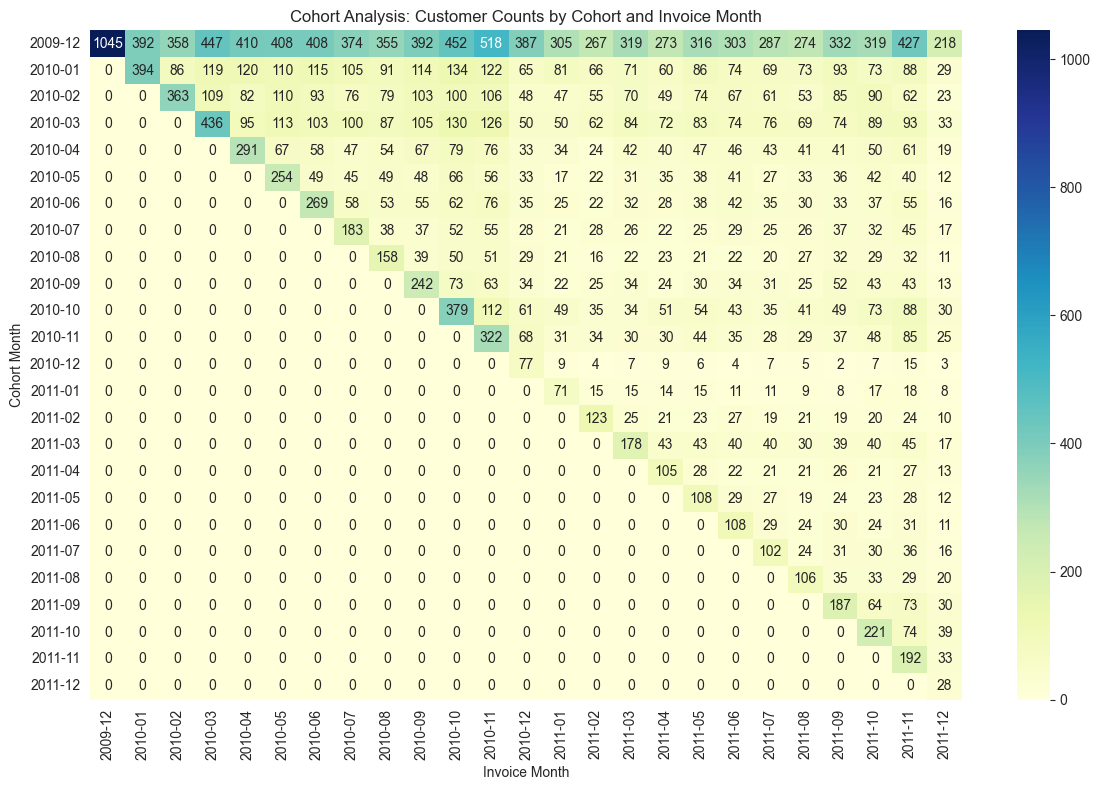

In [36]:
# Create a pivot table of the number of unique customers by CohortMonth and InvoiceMonth
cohort_counts = cohort_df.groupby(['CohortMonth', 'InvoiceMonth'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_counts.pivot(index='CohortMonth', columns='InvoiceMonth', values='CustomerID')

print("Cohort Analysis Pivot Table (Customer Counts):\n", cohort_pivot.head())

# Visualize the retention rates as a heatmap (percentage format can be calculated if desired)
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot.fillna(0), annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Cohort Analysis: Customer Counts by Cohort and Invoice Month")
plt.xlabel("Invoice Month")
plt.ylabel("Cohort Month")
plt.tight_layout()
plt.show()

## 15. Key Findings and Next Steps

**Key Findings:**
- The dataset is large with over one million transactions and eight standardized columns.
- Missing data exists primarily in the `CustomerID` and `Description` columns.
- Cancellations represent approximately 1.83% of total invoices.
- Revenue is highly driven by transaction quantity rather than unit price.
- Seasonality is evident with peaks and troughs in monthly revenue, suggesting the need for seasonal modeling.
- Outlier analysis confirms skewed distributions for both `Quantity` and `UnitPrice`.
- Top products differ when ranked by quantity versus revenue, emphasizing different business strategies.
- The UK dominates in country-level revenue.
- Basic text analysis provides insights into common product description terms.
- RFM segmentation and cohort analysis offer further avenues for customer-specific insights.

**Next Steps:**
1. **Data Preprocessing:**  
   - Handle missing values and outliers.
   - Perform necessary transformations (e.g., logarithmic scaling) where appropriate.
2. **Feature Engineering:**  
   - Engineer time-series features, extract seasonality dummy variables, and explore interaction terms.
   - Utilize text-based features from the `Description` field.
3. **Forecasting and Anomaly Detection:**  
   - Develop forecasting models (seasonal ARIMA, Prophet, etc.).
   - Explore anomaly detection techniques.
4. **Customer Segmentation:**  
   - Leverage RFM and cohort findings for targeted marketing or personalized promotions.

This notebook provides a solid exploratory foundation for these further analyses.

## Notebook Documentation and Clarity

All sections include detailed markdown explanations alongside code cells, ensuring that:
- Assumptions are clearly stated.
- Each visualization is properly annotated.
- Actionable insights are identified to guide subsequent preprocessing and modeling stages.
